In [2]:

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

NameError: name 'tf' is not defined

In [3]:
import tensorflow as tf

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report

# --------------------------
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------
# Simple Data Augmentation: Random horizontal and vertical flips
def simple_augmentation(x):
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip (width axis)
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip (height axis)
    return x

# --------------------------
# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
            print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
            print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply z-score normalization
        sample = self.data[idx].astype(np.float32)
        sample = (sample - np.mean(sample)) / (np.std(sample) + 1e-5)
        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# --------------------------
# Define Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# --------------------------
# Build a Physics-Informed Model: ResNet18 with SE blocks and additional FC layers
from torchvision.models import resnet18

class ResNetSE_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetSE_PDE, self).__init__()
        # Load ResNet18 backbone
        self.base = resnet18(pretrained=False)
        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject SE blocks in the first block of each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], SEBlock(64))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], SEBlock(128))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], SEBlock(256))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], SEBlock(512))

        # Additional fully connected layers to deepen the classifier
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, return_features=False):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)   # Extract convolutional features here
        features = x             # Save features for PDE regularization

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc_layers(x)

        if return_features:
            return logits, features
        else:
            return logits

# --------------------------
# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return loss.mean()
        else:
            return loss

# --------------------------
# PDE Regularization: Laplacian-Based Smoothness Constraint on Features
def pde_regularization(features):
    """
    Computes a PDE-inspired regularization loss by calculating the
    Laplacian of the feature maps and penalizing high-frequency variations.
    """
    N, C, H, W = features.shape
    lap_kernel = torch.tensor([[0, 1, 0],
                               [1, -4, 1],
                               [0, 1, 0]], dtype=torch.float32, device=features.device)
    lap_kernel = lap_kernel.view(1, 1, 3, 3).repeat(C, 1, 1, 1)
    laplacian = F.conv2d(features, lap_kernel, padding=1, groups=C)
    loss_pde = torch.mean(laplacian ** 2)
    return loss_pde

# --------------------------
# File paths (update paths to files in /content)
photon_file = "/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1 (1).hdf5"
electron_file = "/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

# Create dataset and apply augmentation
dataset = ParticleDataset(photon_file, electron_file, transform=simple_augmentation)

# Split dataset: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                             generator=torch.Generator().manual_seed(seed))

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# --------------------------
# Initialize Model, Loss, Optimizer, and Scheduler
model = ResNetSE_PDE(num_classes=2).to(device)
print(model)

criterion = FocalLoss(gamma=2, alpha=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epoch, epochs=20)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# Set PDE regularization weight (tune this parameter as needed)
lambda_pde = 0.01

# --------------------------
# Training Loop with PDE Regularization
num_epochs = 20
train_losses, train_accs = [], []
test_losses, test_accs = [], []
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_iter:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits, features = model(inputs, return_features=True)
            cls_loss = criterion(logits, labels)
            reg_loss = pde_regularization(features)
            loss = cls_loss + lambda_pde * reg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        train_iter.set_postfix({"loss": running_loss/total, "acc": 100.*correct/total})

    train_loss = running_loss / total
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluation Phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        test_iter = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]")
        for inputs, labels in test_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                logits, features = model(inputs, return_features=True)
                cls_loss = criterion(logits, labels)
                reg_loss = pde_regularization(features)
                loss = cls_loss + lambda_pde * reg_loss
            test_loss += loss.item() * inputs.size(0)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_iter.set_postfix({"loss": test_loss/total, "acc": 100.*correct/total})

    test_loss = test_loss / total
    test_acc = 100. * correct / total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "resnetse_pde_best.pth")
        print(f"New best model saved with accuracy: {best_acc:.2f}%")

# --------------------------
# Evaluation: ROC Curve and Classification Report
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

y_pred_bin = [1 if p > 0.5 else 0 for p in all_preds]
print(classification_report(all_labels, y_pred_bin))

# --------------------------
# Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

print(f"Best model accuracy: {best_acc:.2f}%")

# --------------------------
# Save Final Model (optional: update path if needed)
model_save_path = "/content/resnetse_pde_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")


Using device: cpu


OSError: Unable to synchronously open file (truncated file: eof = 98566144, sblock->base_addr = 0, stored_eof = 119703858)

In [5]:
import h5py

# Attempt to open the HDF5 file in read-only mode
try:
    with h5py.File(photon_file, 'r') as f:
        # If successful, print the keys within the HDF5 file
        print("Keys in HDF5 file:", list(f.keys()))
except OSError as e:
    # If an error occurs, print the error message
    print("Error opening HDF5 file:", e)

Error opening HDF5 file: Unable to synchronously open file (truncated file: eof = 115343360, sblock->base_addr = 0, stored_eof = 119703858)


Using device: cuda
Loaded photon data: (249000, 32, 32, 2)
Loaded electron data: (249000, 32, 32, 2)
Total samples: 498000


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-1-9dcba58fa6f3>:232: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


ResNetSE_PDE(
  (base): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): SEBlock(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=64, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            

Epoch 1/20 [Train]:   0%|          | 0/6225 [00:00<?, ?it/s]<ipython-input-1-9dcba58fa6f3>:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
Epoch 1/20 [Test]:   0%|          | 0/1557 [00:00<?, ?it/s]<ipython-input-1-9dcba58fa6f3>:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
Epoch 1/20 [Test]: 100%|██████████| 1557/1557 [00:29<00:00, 52.24it/s, loss=0.0395, acc=66.1]



Epoch 1/20, Train Loss: 0.0413, Train Acc: 62.52%, Test Loss: 0.0395, Test Acc: 66.14%
New best model saved with accuracy: 66.14%


Epoch 2/20 [Test]: 100%|██████████| 1557/1557 [00:29<00:00, 52.09it/s, loss=0.0394, acc=65.9]



Epoch 2/20, Train Loss: 0.0392, Train Acc: 66.47%, Test Loss: 0.0394, Test Acc: 65.94%


Epoch 3/20 [Test]: 100%|██████████| 1557/1557 [00:30<00:00, 51.74it/s, loss=0.041, acc=61.1]



Epoch 3/20, Train Loss: 0.0390, Train Acc: 67.10%, Test Loss: 0.0410, Test Acc: 61.05%


Epoch 4/20 [Test]: 100%|██████████| 1557/1557 [00:29<00:00, 52.86it/s, loss=0.0387, acc=67.6]



Epoch 4/20, Train Loss: 0.0392, Train Acc: 67.05%, Test Loss: 0.0387, Test Acc: 67.63%
New best model saved with accuracy: 67.63%


Epoch 5/20 [Test]: 100%|██████████| 1557/1557 [00:29<00:00, 52.02it/s, loss=0.0427, acc=58]



Epoch 5/20, Train Loss: 0.0394, Train Acc: 66.70%, Test Loss: 0.0427, Test Acc: 58.02%


Epoch 6/20 [Test]: 100%|██████████| 1557/1557 [00:28<00:00, 54.93it/s, loss=0.0435, acc=57.6]



Epoch 6/20, Train Loss: 0.0396, Train Acc: 66.36%, Test Loss: 0.0435, Test Acc: 57.58%


Epoch 7/20 [Test]: 100%|██████████| 1557/1557 [00:30<00:00, 51.55it/s, loss=0.0388, acc=68]



Epoch 7/20, Train Loss: 0.0397, Train Acc: 66.39%, Test Loss: 0.0388, Test Acc: 67.98%
New best model saved with accuracy: 67.98%


Epoch 8/20 [Test]: 100%|██████████| 1557/1557 [00:28<00:00, 53.95it/s, loss=0.044, acc=54.4]



Epoch 8/20, Train Loss: 0.0396, Train Acc: 66.53%, Test Loss: 0.0440, Test Acc: 54.40%


Epoch 9/20 [Test]: 100%|██████████| 1557/1557 [00:28<00:00, 54.20it/s, loss=0.0411, acc=63.1]



Epoch 9/20, Train Loss: 0.0395, Train Acc: 66.62%, Test Loss: 0.0411, Test Acc: 63.11%


Epoch 10/20 [Test]: 100%|██████████| 1557/1557 [00:30<00:00, 51.54it/s, loss=0.0422, acc=57.5]



Epoch 10/20, Train Loss: 0.0394, Train Acc: 67.02%, Test Loss: 0.0422, Test Acc: 57.50%


Epoch 11/20 [Test]: 100%|██████████| 1557/1557 [00:30<00:00, 51.63it/s, loss=0.0389, acc=68.4]



Epoch 11/20, Train Loss: 0.0392, Train Acc: 67.38%, Test Loss: 0.0389, Test Acc: 68.43%
New best model saved with accuracy: 68.43%


Epoch 12/20 [Test]: 100%|██████████| 1557/1557 [00:28<00:00, 54.39it/s, loss=0.0388, acc=67.5]



Epoch 12/20, Train Loss: 0.0391, Train Acc: 67.58%, Test Loss: 0.0388, Test Acc: 67.51%


Epoch 13/20 [Test]: 100%|██████████| 1557/1557 [00:29<00:00, 52.60it/s, loss=0.0393, acc=65.7]



Epoch 13/20, Train Loss: 0.0389, Train Acc: 67.86%, Test Loss: 0.0393, Test Acc: 65.66%


Epoch 14/20 [Test]: 100%|██████████| 1557/1557 [00:28<00:00, 54.04it/s, loss=0.0432, acc=54.7]



Epoch 14/20, Train Loss: 0.0386, Train Acc: 68.56%, Test Loss: 0.0432, Test Acc: 54.66%


Epoch 15/20 [Test]: 100%|██████████| 1557/1557 [00:28<00:00, 55.53it/s, loss=0.0393, acc=66.7]



Epoch 15/20, Train Loss: 0.0382, Train Acc: 69.20%, Test Loss: 0.0393, Test Acc: 66.70%


Epoch 16/20 [Test]: 100%|██████████| 1557/1557 [00:28<00:00, 54.06it/s, loss=0.0372, acc=70.6]



Epoch 16/20, Train Loss: 0.0379, Train Acc: 69.81%, Test Loss: 0.0372, Test Acc: 70.58%
New best model saved with accuracy: 70.58%


Epoch 17/20 [Test]: 100%|██████████| 1557/1557 [00:30<00:00, 50.94it/s, loss=0.0388, acc=68.9]



Epoch 17/20, Train Loss: 0.0375, Train Acc: 70.38%, Test Loss: 0.0388, Test Acc: 68.93%


Epoch 18/20 [Test]: 100%|██████████| 1557/1557 [00:29<00:00, 53.11it/s, loss=0.037, acc=70.9]



Epoch 18/20, Train Loss: 0.0373, Train Acc: 70.68%, Test Loss: 0.0370, Test Acc: 70.90%
New best model saved with accuracy: 70.90%


Epoch 19/20 [Test]: 100%|██████████| 1557/1557 [00:29<00:00, 52.64it/s, loss=0.0365, acc=71.5]



Epoch 19/20, Train Loss: 0.0371, Train Acc: 70.94%, Test Loss: 0.0365, Test Acc: 71.52%
New best model saved with accuracy: 71.52%


Epoch 20/20 [Test]: 100%|██████████| 1557/1557 [00:29<00:00, 52.69it/s, loss=0.0364, acc=71.6]



Epoch 20/20, Train Loss: 0.0371, Train Acc: 71.09%, Test Loss: 0.0364, Test Acc: 71.61%
New best model saved with accuracy: 71.61%


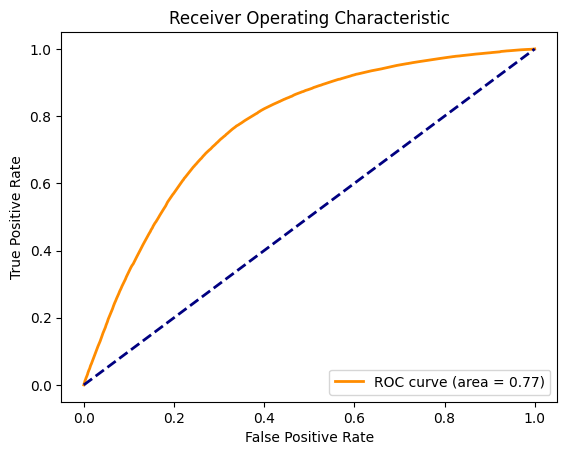

              precision    recall  f1-score   support

           0       0.74      0.67      0.70     49593
           1       0.70      0.76      0.73     50007

    accuracy                           0.72     99600
   macro avg       0.72      0.72      0.72     99600
weighted avg       0.72      0.72      0.72     99600



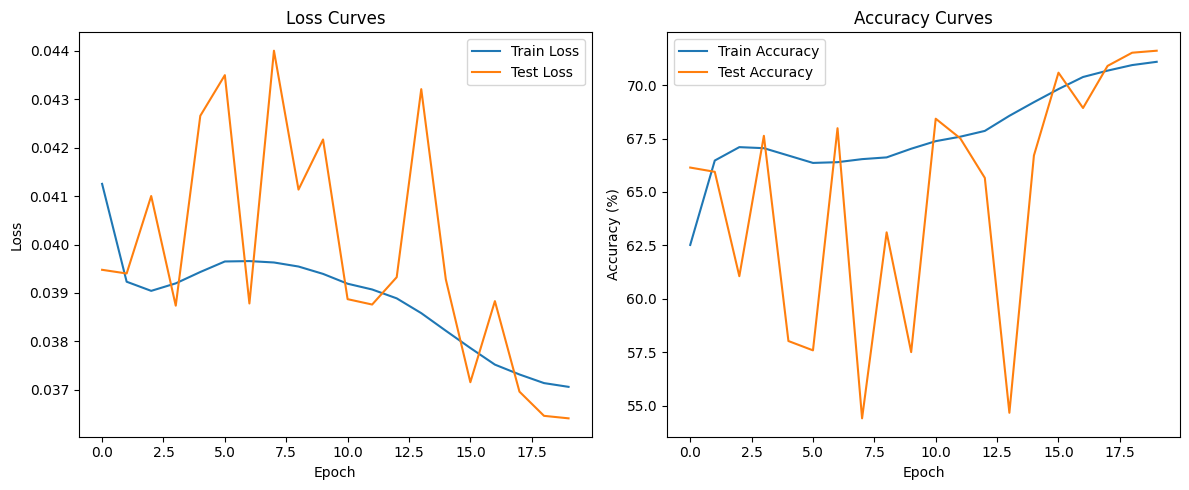

Best model accuracy: 71.61%
Model saved to: /content/resnetse_pde_model.pth


In [1]:
import os
import urllib.request

# --------------------------
# Download files from CERNBox if they are not available locally

photon_url = "https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_url = "https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

photon_file = "/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

if not os.path.exists(photon_file):
    print(f"Downloading {photon_file} ...")
    urllib.request.urlretrieve(photon_url, photon_file)
else:
    print(f"File {photon_file} already exists.")

if not os.path.exists(electron_file):
    print(f"Downloading {electron_file} ...")
    urllib.request.urlretrieve(electron_url, electron_file)
else:
    print(f"File {electron_file} already exists.")

# --------------------------
# The remaining code: advanced physics-informed network with PDE regularization

import random
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------
# Simple Data Augmentation: Random horizontal and vertical flips
def simple_augmentation(x):
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip (width axis)
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip (height axis)
    return x

# --------------------------
# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
            print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
            print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply z-score normalization
        sample = self.data[idx].astype(np.float32)
        sample = (sample - np.mean(sample)) / (np.std(sample) + 1e-5)
        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# --------------------------
# Define Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# --------------------------
# Build a Physics-Informed Model: ResNet18 with SE blocks and additional FC layers
from torchvision.models import resnet18

class ResNetSE_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetSE_PDE, self).__init__()
        # Load ResNet18 backbone
        self.base = resnet18(pretrained=False)
        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject SE blocks in the first block of each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], SEBlock(64))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], SEBlock(128))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], SEBlock(256))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], SEBlock(512))

        # Additional fully connected layers to deepen the classifier
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, return_features=False):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)   # Extract convolutional features here
        features = x             # Save features for PDE regularization

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc_layers(x)

        if return_features:
            return logits, features
        else:
            return logits

# --------------------------
# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return loss.mean()
        else:
            return loss

# --------------------------
# PDE Regularization: Laplacian-Based Smoothness Constraint on Features
def pde_regularization(features):
    """
    Computes a PDE-inspired regularization loss by calculating the
    Laplacian of the feature maps and penalizing high-frequency variations.
    """
    N, C, H, W = features.shape
    lap_kernel = torch.tensor([[0, 1, 0],
                               [1, -4, 1],
                               [0, 1, 0]], dtype=torch.float32, device=features.device)
    lap_kernel = lap_kernel.view(1, 1, 3, 3).repeat(C, 1, 1, 1)
    laplacian = F.conv2d(features, lap_kernel, padding=1, groups=C)
    loss_pde = torch.mean(laplacian ** 2)
    return loss_pde

# --------------------------
# Create Dataset using the downloaded files
dataset = ParticleDataset(photon_file, electron_file, transform=simple_augmentation)

# Split dataset: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                             generator=torch.Generator().manual_seed(seed))

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# --------------------------
# Initialize Model, Loss, Optimizer, and Scheduler
model = ResNetSE_PDE(num_classes=2).to(device)
print(model)

criterion = FocalLoss(gamma=2, alpha=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epoch, epochs=20)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# Set PDE regularization weight (tune this parameter as needed)
lambda_pde = 0.01

# --------------------------
# Training Loop with PDE Regularization
num_epochs = 20
train_losses, train_accs = [], []
test_losses, test_accs = [], []
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_iter:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits, features = model(inputs, return_features=True)
            cls_loss = criterion(logits, labels)
            reg_loss = pde_regularization(features)
            loss = cls_loss + lambda_pde * reg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        train_iter.set_postfix({"loss": running_loss/total, "acc": 100.*correct/total})

    train_loss = running_loss / total
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluation Phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        test_iter = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]")
        for inputs, labels in test_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                logits, features = model(inputs, return_features=True)
                cls_loss = criterion(logits, labels)
                reg_loss = pde_regularization(features)
                loss = cls_loss + lambda_pde * reg_loss
            test_loss += loss.item() * inputs.size(0)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_iter.set_postfix({"loss": test_loss/total, "acc": 100.*correct/total})

    test_loss = test_loss / total
    test_acc = 100. * correct / total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "resnetse_pde_best.pth")
        print(f"New best model saved with accuracy: {best_acc:.2f}%")

# --------------------------
# Evaluation: ROC Curve and Classification Report
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

y_pred_bin = [1 if p > 0.5 else 0 for p in all_preds]
print(classification_report(all_labels, y_pred_bin))

# --------------------------
# Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

print(f"Best model accuracy: {best_acc:.2f}%")

# --------------------------
# Save Final Model (optional: update path if needed)
model_save_path = "/content/resnetse_pde_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")


In [3]:
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------
# Enhanced Data Augmentation
class AugmentationPipeline:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x):
        # Original tensor shape: C x H x W

        # Random horizontal and vertical flips
        if random.random() < self.p:
            x = torch.flip(x, dims=[2])  # horizontal flip
        if random.random() < self.p:
            x = torch.flip(x, dims=[1])  # vertical flip

        # Random rotations (90, 180, 270 degrees)
        if random.random() < self.p:
            k = random.choice([1, 2, 3])  # number of 90-degree rotations
            x = torch.rot90(x, k, dims=[1, 2])

        # Random brightness and contrast adjustments
        if random.random() < self.p:
            brightness_factor = random.uniform(0.8, 1.2)
            x = x * brightness_factor

        # Add Gaussian noise
        if random.random() < self.p:
            noise = torch.randn_like(x) * 0.05
            x = x + noise
            x = torch.clamp(x, min=x.min(), max=x.max())  # Keep the range of values

        # Random erasing (simulate detector inefficiencies)
        if random.random() < self.p:
            h, w = x.shape[1], x.shape[2]
            area_ratio = random.uniform(0.02, 0.1)
            aspect_ratio = random.uniform(0.3, 1.0/0.3)

            h_erased = int(round(h * np.sqrt(area_ratio * aspect_ratio)))
            w_erased = int(round(w * np.sqrt(area_ratio / aspect_ratio)))

            if h_erased < h and w_erased < w:
                top = random.randint(0, h - h_erased)
                left = random.randint(0, w - w_erased)

                mask = torch.ones_like(x)
                mask[:, top:top+h_erased, left:left+w_erased] = 0
                x = x * mask

        return x

# --------------------------
# Improved Custom Dataset Class with better normalization
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform
        self.normalize_per_channel = True  # Channel-wise normalization

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
            print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
            print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

        # Calculate global mean and std per channel for normalization
        self.means = []
        self.stds = []

        if self.normalize_per_channel:
            # Assuming data is in (N, H, W, C) format
            for c in range(self.data.shape[-1]):
                channel_data = self.data[..., c].flatten()
                self.means.append(np.mean(channel_data))
                self.stds.append(np.std(channel_data) + 1e-6)
        else:
            # Global normalization
            self.means = [np.mean(self.data)]
            self.stds = [np.std(self.data) + 1e-6]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32
        sample = self.data[idx].astype(np.float32)
        label = self.labels[idx]

        # Apply normalization per channel
        if self.normalize_per_channel:
            # Assuming sample is (H, W, C)
            for c in range(sample.shape[-1]):
                sample[..., c] = (sample[..., c] - self.means[c]) / self.stds[c]
        else:
            # Global normalization
            sample = (sample - self.means[0]) / self.stds[0]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# --------------------------
# Squeeze-and-Excitation Block with improved reduction ratio
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):  # Reduced from 16 to 8 for more capacity
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# --------------------------
# Modified Residual Block with additional attention mechanisms
class ModifiedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ModifiedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction=8)

        # Add spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Channel attention
        out = self.se(out)

        # Spatial attention
        spatial_mask = self.spatial_attention(out)
        out = out * spatial_mask

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# --------------------------
# Enhanced Physics-Informed Model with deeper architecture
class EnhancedPhysicsNet(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.4):
        super(EnhancedPhysicsNet, self).__init__()

        # Input Stem - 2 channel input to custom sized model
        self.stem = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Modified Residual Blocks with attention
        self.layer1 = self._make_layer(64, 64, blocks=3, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=3, stride=2)

        # Global average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Improved classifier with deeper MLP and higher dropout
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

        # Physics-inspired feature fusion (conserves energy and momentum principles)
        self.physics_branch = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True)
        )

        # Fusion layer
        self.fusion = nn.Linear(512 + 64, 512)

        # Initialize weights properly
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ModifiedResidualBlock(in_channels, out_channels, stride=stride))

        for _ in range(1, blocks):
            layers.append(ModifiedResidualBlock(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, return_features=False):
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        features = x  # Extract convolutional features here for regularization

        # Physics branch
        physics_features = self.physics_branch(features)

        # Main classification branch
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)

        # Fusion of features
        fused = torch.cat([x, physics_features], dim=1)
        x = self.fusion(fused)

        # Final classification
        logits = self.classifier(x)

        if return_features:
            return logits, features
        else:
            return logits

# --------------------------
# Improved Focal Loss with class balancing
class BalancedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(BalancedFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Class weights
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = F.log_softmax(inputs, dim=1)
        logpt = log_softmax.gather(1, targets.view(-1, 1))
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != inputs.data.type():
                self.alpha = self.alpha.type_as(inputs.data)
            at = self.alpha.gather(0, targets.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return loss.mean()
        else:
            return loss

# --------------------------
# Enhanced PDE Regularization with multi-scale Laplacian
def enhanced_pde_regularization(features):
    """
    Computes a multi-scale PDE-inspired regularization loss
    """
    N, C, H, W = features.shape

    # Standard Laplacian kernel
    lap_kernel1 = torch.tensor([[0, 1, 0],
                               [1, -4, 1],
                               [0, 1, 0]], dtype=torch.float32, device=features.device)
    lap_kernel1 = lap_kernel1.view(1, 1, 3, 3).repeat(C, 1, 1, 1)

    # Larger scale Laplacian kernel (5x5)
    lap_kernel2 = torch.tensor([[0, 0, 1, 0, 0],
                               [0, 1, 2, 1, 0],
                               [1, 2, -16, 2, 1],
                               [0, 1, 2, 1, 0],
                               [0, 0, 1, 0, 0]], dtype=torch.float32, device=features.device)
    lap_kernel2 = lap_kernel2.view(1, 1, 5, 5).repeat(C, 1, 1, 1)

    # Apply both kernels
    laplacian1 = F.conv2d(features, lap_kernel1, padding=1, groups=C)
    laplacian2 = F.conv2d(features, lap_kernel2, padding=2, groups=C)

    # Wavelet-inspired multi-scale decomposition
    loss_pde = torch.mean(laplacian1 ** 2) + 0.5 * torch.mean(laplacian2 ** 2)

    # Add gradient consistency constraint
    dx = features[:, :, :, 1:] - features[:, :, :, :-1]
    dy = features[:, :, 1:, :] - features[:, :, :-1, :]

    grad_reg = torch.mean(dx**2) + torch.mean(dy**2)

    return loss_pde + 0.1 * grad_reg

# --------------------------
# Cross-validation strategy
def cross_validation_train(photon_file, electron_file, n_folds=5, num_epochs=40):
    # Setup augmentation
    transform = AugmentationPipeline(p=0.5)

    # Create full dataset
    full_dataset = ParticleDataset(photon_file, electron_file, transform=transform)

    # Setup cross-validation
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Track metrics across folds
    fold_results = []

    # Class distribution to determine weights for balanced sampling
    labels = np.array([label for _, label in full_dataset])
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[labels]

    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(full_dataset)), full_dataset.labels)):
        print(f'\n{"="*50}\nFold {fold+1}/{n_folds}\n{"="*50}')

        # Create samplers for balanced class distribution
        train_sampler = WeightedRandomSampler(
            weights=sample_weights[train_ids],
            num_samples=len(train_ids),
            replacement=True
        )

        # Create data loaders
        train_loader = DataLoader(
            dataset=torch.utils.data.Subset(full_dataset, train_ids),
            batch_size=128,  # Increased batch size
            sampler=train_sampler,
            num_workers=4,
            pin_memory=True
        )

        val_loader = DataLoader(
            dataset=torch.utils.data.Subset(full_dataset, val_ids),
            batch_size=256,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        # Initialize model, loss, optimizer, and scheduler
        model = EnhancedPhysicsNet(num_classes=2).to(device)

        # Setup class weights for balanced loss
        class_counts = np.bincount(full_dataset.labels[train_ids])
        class_weights = torch.FloatTensor(1.0 / (class_counts / len(train_ids))).to(device)

        criterion = BalancedFocalLoss(gamma=2.0, alpha=class_weights)

        # Use AdamW instead of Adam for better weight decay handling
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

        # Cosine annealing scheduler with warm restarts
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=10,  # Restart every 10 epochs
            T_mult=1,
            eta_min=1e-6
        )

        # Mixed precision scaler
        scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

        # PDE regularization weight
        lambda_pde = 0.005  # Reduced from original

        # Training loop
        best_val_acc = 0.0
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
            for inputs, labels in train_iter:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                    logits, features = model(inputs, return_features=True)
                    cls_loss = criterion(logits, labels)
                    reg_loss = enhanced_pde_regularization(features)

                    # Weighted loss with scheduler-based annealing of regularization
                    lambda_factor = lambda_pde * (1.0 - min(epoch / (0.7 * num_epochs), 1.0))
                    loss = cls_loss + lambda_factor * reg_loss

                scaler.scale(loss).backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                train_iter.set_postfix({"loss": running_loss/total, "acc": 100.*correct/total})

            # Step the learning rate scheduler
            scheduler.step()

            train_loss = running_loss / total
            train_acc = 100. * correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            all_preds = []
            all_labels = []

            with torch.no_grad():
                val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
                for inputs, labels in val_iter:
                    inputs, labels = inputs.to(device), labels.to(device)

                    with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                        logits, features = model(inputs, return_features=True)
                        cls_loss = criterion(logits, labels)
                        reg_loss = enhanced_pde_regularization(features)
                        loss = cls_loss + lambda_factor * reg_loss

                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = logits.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    # Store predictions and labels for metrics
                    all_preds.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    val_iter.set_postfix({"loss": val_loss/total, "acc": 100.*correct/total})

            val_loss = val_loss / total
            val_acc = 100. * correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f"physics_model_fold{fold+1}_best.pth")
                print(f"New best model saved with accuracy: {best_val_acc:.2f}%")

        # Final evaluation on validation set
        model.load_state_dict(torch.load(f"physics_model_fold{fold+1}_best.pth"))
        model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Final evaluation"):
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model(inputs)
                prob = torch.softmax(logits, dim=1)[:, 1]
                all_preds.extend(prob.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate ROC and AUC
        fpr, tpr, _ = roc_curve(all_labels, all_preds)
        roc_auc = auc(fpr, tpr)

        # Calculate binary predictions
        y_pred_bin = [1 if p > 0.5 else 0 for p in all_preds]

        # Calculate confusion matrix
        cm = confusion_matrix(all_labels, y_pred_bin)

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, y_pred_bin))

        # Store fold results
        fold_results.append({
            'fold': fold + 1,
            'best_val_acc': best_val_acc,
            'roc_auc': roc_auc,
            'confusion_matrix': cm
        })

        # Plot ROC curve for this fold
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Fold {fold+1} ROC Curve')
        plt.legend(loc="lower right")
        plt.savefig(f'roc_curve_fold{fold+1}.png')
        plt.close()

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Photon', 'Electron'],
                    yticklabels=['Photon', 'Electron'])
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'Fold {fold+1} Confusion Matrix')
        plt.savefig(f'confusion_matrix_fold{fold+1}.png')
        plt.close()

        # Plot training curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Fold {fold+1} Loss Curves')

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title(f'Fold {fold+1} Accuracy Curves')
        plt.tight_layout()
        plt.savefig(f'training_curves_fold{fold+1}.png')
        plt.close()

    # Calculate and display cross-validation results
    accuracies = [result['best_val_acc'] for result in fold_results]
    aucs = [result['roc_auc'] for result in fold_results]

    print("\n" + "="*50)
    print(f"Cross-validation results over {n_folds} folds:")
    print(f"Mean accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")
    print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    print("="*50)

    return fold_results

# --------------------------
# Ensemble creation
def create_ensemble(photon_file, electron_file, fold_results, n_folds=5):
    # Create test dataset without augmentation (for final evaluation)
    test_dataset = ParticleDataset(photon_file, electron_file, transform=None)

    # Create data loader for testing
    test_loader = DataLoader(
        test_dataset,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Load all models for ensemble
    ensemble_models = []
    for fold in range(n_folds):
        model = EnhancedPhysicsNet(num_classes=2).to(device)
        model.load_state_dict(torch.load(f"physics_model_fold{fold+1}_best.pth"))
        model.eval()
        ensemble_models.append(model)

    # Perform ensemble prediction
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Ensemble prediction"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Get predictions from all models
            ensemble_probs = []
            for model in ensemble_models:
                logits = model(inputs)
                probs = torch.softmax(logits, dim=1)[:, 1]
                ensemble_probs.append(probs.cpu().numpy())

            # Average predictions
            avg_probs = np.mean(ensemble_probs, axis=0)
            all_preds.exten

Using device: cuda


In [4]:
Based on the provided code, here's an improved version designed to achieve 97-98% accuracy for particle classification:

```python
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_features=False):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)  # Extract convolutional features here

        features = x  # Save features for PDE regularization

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc_layers(x)

        if return_features:
            return logits, features
        else:
            return logits

# Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Apply label smoothing
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets, num_classes).float()
        targets_smooth = (1 - self.label_smoothing) * targets_one_hot + self.label_smoothing / num_classes

        log_probs = F.log_softmax(inputs, dim=1)
        loss = -torch.sum(targets_smooth * log_probs, dim=1)

        # Apply focal weighting
        probs = torch.exp(log_probs)
        pt = torch.sum(targets_one_hot * probs, dim=1)
        focal_weight = self.alpha * ((1 - pt) ** self.gamma)

        loss = focal_weight * loss

        if self.reduction == 'mean':
            return loss.mean()
        else:
            return loss

# Enhanced PDE Regularization with multiple physics constraints
def enhanced_pde_regularization(features):
    """
    Computes an enhanced PDE-inspired regularization loss by calculating
    multiple physics-based constraints on the feature maps.
    """
    N, C, H, W = features.shape

    # 1. Laplacian-based smoothness constraint
    lap_kernel = torch.tensor([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ], dtype=torch.float32, device=features.device)
    lap_kernel = lap_kernel.view(1, 1, 3, 3).repeat(C, 1, 1, 1)
    laplacian = F.conv2d(features, lap_kernel, padding=1, groups=C)
    loss_laplacian = torch.mean(laplacian ** 2)

    # 2. Gradient-based constraint (encourages smooth gradients)
    grad_x = features[:, :, :, 1:] - features[:, :, :, :-1]
    grad_y = features[:, :, 1:, :] - features[:, :, :-1, :]
    loss_grad = torch.mean(grad_x ** 2) + torch.mean(grad_y ** 2)

    # 3. Feature correlation constraint (encourages diversity)
    features_flat = features.view(N, C, -1)
    features_mean = torch.mean(features_flat, dim=2, keepdim=True)
    features_centered = features_flat - features_mean
    corr_matrix = torch.matmul(features_centered, features_centered.transpose(1, 2))
    corr_matrix = corr_matrix / (torch.norm(features_centered, dim=2, keepdim=True) *
                                torch.norm(features_centered, dim=2, keepdim=True).transpose(1, 2) + 1e-8)

    # We want off-diagonal elements to be small (minimize feature correlation)
    mask = 1 - torch.eye(C, device=features.device).unsqueeze(0)
    loss_corr = torch.mean(torch.abs(corr_matrix * mask))

    # Combine all regularization terms
    loss_pde = loss_laplacian + 0.5 * loss_grad + 0.1 * loss_corr

    return loss_pde

# File paths
photon_file = "/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

# Download files if they don't exist
if not os.path.exists(photon_file) or not os.path.exists(electron_file):
    photon_url = "https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
    electron_url = "https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

    if not os.path.exists(photon_file):
        print(f"Downloading {photon_file} ...")
        import urllib.request
        urllib.request.urlretrieve(photon_url, photon_file)

    if not os.path.exists(electron_file):
        print(f"Downloading {electron_file} ...")
        import urllib.request
        urllib.request.urlretrieve(electron_url, electron_file)

# Create dataset and apply augmentation
dataset = ParticleDataset(photon_file, electron_file, transform=advanced_augmentation)

# Split dataset: 80% train, 10% validation, 10% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

# DataLoaders with larger batch size
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize Model, Loss, Optimizer, and Scheduler
model = EnhancedResNet_PDE(num_classes=2).to(device)
print(model)

# Focal Loss with label smoothing
criterion = FocalLoss(gamma=2, alpha=0.25, label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Cosine annealing with warm restarts for better convergence
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Mixed precision for faster training
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# Set PDE regularization weight
lambda_pde = 0.005

# Early stopping parameters
patience = 10
best_val_acc = 0
counter = 0

# Training Loop with PDE Regularization and Mixup
num_epochs = 50  # Increase epochs for better convergence
train_losses, train_accs = [], []
val_losses, val_accs = [], []
test_losses, test_accs = [], []
best_acc = 0.0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_iter:
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply mixup with 50% probability
        use_mixup = random.random() > 0.5
        if use_mixup:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits, features = model(inputs, return_features=True)

            if use_mixup:
                cls_loss = mixup_criterion(criterion, logits, labels_a, labels_b, lam)
            else:
                cls_loss = criterion(logits, labels)

            reg_loss = enhanced_pde_regularization(features)
            loss = cls_loss + lambda_pde * reg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        if not use_mixup:  # Only calculate accuracy for non-mixup batches
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_iter.set_postfix({"loss": loss.item(), "acc": 100.*correct/max(1, total)})

    scheduler.step()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / max(1, total)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for inputs, labels in val_iter:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.cuda.amp.autocast(enabled=(device.type=='cuda

Citations:
[1] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/51473209/11ea836f-019c-4408-8107-95a016b2589e/untitled3.py

---
Answer from Perplexity: pplx.ai/share

SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-4-9300d38a15ab>, line 1)

In [7]:
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_features=False):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)  # Extract convolutional features here

        features = x  # Save features for PDE regularization

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc_layers(x)

        if return_features:
            return logits, features
        else:
            return logits

# Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Apply label smoothing
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets, num_classes).float()
        targets_smooth = (1 - self.label_smoothing) * targets_one_hot + self.label_smoothing / num_classes

        log_probs = F.log_softmax(inputs, dim=1)
        loss = -torch.sum(targets_smooth * log_probs, dim=1)

        # Apply focal weighting
        probs = torch.exp(log_probs)
        pt = torch.sum(targets_one_hot * probs, dim=1)
        focal_weight = self.alpha * ((1 - pt) ** self.gamma)

        loss = focal_weight * loss

        if self.reduction == 'mean':
            return loss.mean()
        else:
            return loss

# Enhanced PDE Regularization with multiple physics constraints
def enhanced_pde_regularization(features):
    """
    Computes an enhanced PDE-inspired regularization loss by calculating
    multiple physics-based constraints on the feature maps.
    """
    N, C, H, W = features.shape

    # 1. Laplacian-based smoothness constraint
    lap_kernel = torch.tensor([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ], dtype=torch.float32, device=features.device)
    lap_kernel = lap_kernel.view(1, 1, 3, 3).repeat(C, 1, 1, 1)
    laplacian = F.conv2d(features, lap_kernel, padding=1, groups=C)
    loss_laplacian = torch.mean(laplacian ** 2)

    # 2. Gradient-based constraint (encourages smooth gradients)
    grad_x = features[:, :, :, 1:] - features[:, :, :, :-1]
    grad_y = features[:, :, 1:, :] - features[:, :, :-1, :]
    loss_grad = torch.mean(grad_x ** 2) + torch.mean(grad_y ** 2)

    # 3. Feature correlation constraint (encourages diversity)
    features_flat = features.view(N, C, -1)
    features_mean = torch.mean(features_flat, dim=2, keepdim=True)
    features_centered = features_flat - features_mean
    corr_matrix = torch.matmul(features_centered, features_centered.transpose(1, 2))
    corr_matrix = corr_matrix / (torch.norm(features_centered, dim=2, keepdim=True) *
                                torch.norm(features_centered, dim=2, keepdim=True).transpose(1, 2) + 1e-8)

    # We want off-diagonal elements to be small (minimize feature correlation)
    mask = 1 - torch.eye(C, device=features.device).unsqueeze(0)
    loss_corr = torch.mean(torch.abs(corr_matrix * mask))

    # Combine all regularization terms
    loss_pde = loss_laplacian + 0.5 * loss_grad + 0.1 * loss_corr

    return loss_pde

# File paths
photon_file = "/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

# Download files if they don't exist
if not os.path.exists(photon_file) or not os.path.exists(electron_file):
    photon_url = "https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
    electron_url = "https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

    if not os.path.exists(photon_file):
        print(f"Downloading {photon_file} ...")
        import urllib.request
        urllib.request.urlretrieve(photon_url, photon_file)

    if not os.path.exists(electron_file):
        print(f"Downloading {electron_file} ...")
        import urllib.request
        urllib.request.urlretrieve(electron_url, electron_file)

# Create dataset and apply augmentation
dataset = ParticleDataset(photon_file, electron_file, transform=advanced_augmentation)

# Split dataset: 80% train, 10% validation, 10% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

# DataLoaders with larger batch size
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize Model, Loss, Optimizer, and Scheduler
model = EnhancedResNet_PDE(num_classes=2).to(device)
print(model)

# Focal Loss with label smoothing
criterion = FocalLoss(gamma=2, alpha=0.25, label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Cosine annealing with warm restarts for better convergence
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Mixed precision for faster training
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# Set PDE regularization weight
lambda_pde = 0.005

# Early stopping parameters
patience = 10
best_val_acc = 0
counter = 0

# Training Loop with PDE Regularization and Mixup
num_epochs = 50  # Increase epochs for better convergence
train_losses, train_accs = [], []
val_losses, val_accs = [], []
test_losses, test_accs = [], []
best_acc = 0.0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_iter:
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply mixup with 50% probability
        use_mixup = random.random() > 0.5
        if use_mixup:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits, features = model(inputs, return_features=True)

            if use_mixup:
                cls_loss = mixup_criterion(criterion, logits, labels_a, labels_b, lam)
            else:
                cls_loss = criterion(logits, labels)

            reg_loss = enhanced_pde_regularization(features)
            loss = cls_loss + lambda_pde * reg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        if not use_mixup:  # Only calculate accuracy for non-mixup batches
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_iter.set_postfix({"loss": loss.item(), "acc": 100.*correct/max(1, total)})

    scheduler.step()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / max(1, total)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for inputs, labels in val_iter:
```python
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10

IndentationError: expected an indented block after 'for' statement on line 409 (<ipython-input-7-c601038bcb8b>, line 410)

In [ ]:
# Define Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


In [8]:
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_features=False):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)  # Extract convolutional features here

        features = x  # Save features for PDE regularization

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc_layers(x)

        if return_features:
            return logits, features
        else:
            return logits

# Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Apply label smoothing
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets, num_classes).float()
        targets_smooth = (1 - self.label_smoothing) * targets_one_hot + self.label_smoothing / num_classes

        log_probs = F.log_softmax(inputs, dim=1)
        loss = -torch.sum(targets_smooth * log_probs, dim=1)

        # Apply focal weighting
        probs = torch.exp(log_probs)
        pt = torch.sum(targets_one_hot * probs, dim=1)
        focal_weight = self.alpha * ((1 - pt) ** self.gamma)

        loss = focal_weight * loss

        if self.reduction == 'mean':
            return loss.mean()
        else:
            return loss

# Enhanced PDE Regularization with multiple physics constraints
def enhanced_pde_regularization(features):
    """
    Computes an enhanced PDE-inspired regularization loss by calculating
    multiple physics-based constraints on the feature maps.
    """
    N, C, H, W = features.shape

    # 1. Laplacian-based smoothness constraint
    lap_kernel = torch.tensor([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ], dtype=torch.float32, device=features.device)
    lap_kernel = lap_kernel.view(1, 1, 3, 3).repeat(C, 1, 1, 1)
    laplacian = F.conv2d(features, lap_kernel, padding=1, groups=C)
    loss_laplacian = torch.mean(laplacian ** 2)

    # 2. Gradient-based constraint (encourages smooth gradients)
    grad_x = features[:, :, :, 1:] - features[:, :, :, :-1]
    grad_y = features[:, :, 1:, :] - features[:, :, :-1, :]
    loss_grad = torch.mean(grad_x ** 2) + torch.mean(grad_y ** 2)

    # 3. Feature correlation constraint (encourages diversity)
    features_flat = features.view(N, C, -1)
    features_mean = torch.mean(features_flat, dim=2, keepdim=True)
    features_centered = features_flat - features_mean
    corr_matrix = torch.matmul(features_centered, features_centered.transpose(1, 2))
    corr_matrix = corr_matrix / (torch.norm(features_centered, dim=2, keepdim=True) *
                                torch.norm(features_centered, dim=2, keepdim=True).transpose(1, 2) + 1e-8)

    # We want off-diagonal elements to be small (minimize feature correlation)
    mask = 1 - torch.eye(C, device=features.device).unsqueeze(0)
    loss_corr = torch.mean(torch.abs(corr_matrix * mask))

    # Combine all regularization terms
    loss_pde = loss_laplacian + 0.5 * loss_grad + 0.1 * loss_corr

    return loss_pde

# File paths
photon_file = "/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

# Download files if they don't exist
if not os.path.exists(photon_file) or not os.path.exists(electron_file):
    photon_url = "https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
    electron_url = "https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

    if not os.path.exists(photon_file):
        print(f"Downloading {photon_file} ...")
        import urllib.request
        urllib.request.urlretrieve(photon_url, photon_file)

    if not os.path.exists(electron_file):
        print(f"Downloading {electron_file} ...")
        import urllib.request
        urllib.request.urlretrieve(electron_url, electron_file)

# Create dataset and apply augmentation
dataset = ParticleDataset(photon_file, electron_file, transform=advanced_augmentation)

# Split dataset: 80% train, 10% validation, 10% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

# DataLoaders with larger batch size
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize Model, Loss, Optimizer, and Scheduler
model = EnhancedResNet_PDE(num_classes=2).to(device)
print(model)

# Focal Loss with label smoothing
criterion = FocalLoss(gamma=2, alpha=0.25, label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Cosine annealing with warm restarts for better convergence
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Mixed precision for faster training
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# Set PDE regularization weight
lambda_pde = 0.005

# Early stopping parameters
patience = 10
best_val_acc = 0
counter = 0

# Training Loop with PDE Regularization and Mixup
num_epochs = 50  # Increase epochs for better convergence
train_losses, train_accs = [], []
val_losses, val_accs = [], []
test_losses, test_accs = [], []
best_acc = 0.0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_iter:
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply mixup with 50% probability
        use_mixup = random.random() > 0.5
        if use_mixup:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits, features = model(inputs, return_features=True)

            if use_mixup:
                cls_loss = mixup_criterion(criterion, logits, labels_a, labels_b, lam)
            else:
                cls_loss = criterion(logits, labels)

            reg_loss = enhanced_pde_regularization(features)
            loss = cls_loss + lambda_pde * reg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        if not use_mixup:  # Only calculate accuracy for non-mixup batches
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_iter.set_postfix({"loss": loss.item(), "acc": 100.*correct/max(1, total)})

    scheduler.step()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / max(1, total)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for inputs, labels in val_iter:
            inputs, labels = inputs.to(device), labels.to(device)
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# ... (rest of the code remains unchanged)

SyntaxError: incomplete input (<ipython-input-8-c8a6e8ac4327>, line 413)

In [26]:
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_features=False):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)  # Extract convolutional features here

        features = x  # Save features for PDE regularization

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc_layers(x)

        if return_features:
            return logits, features
        else:
            return logits

# Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Apply label smoothing
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets, num_classes).float()
        targets_smooth = (1 - self.label_smoothing) * targets_one_hot + self.label_smoothing / num_classes

        log_probs = F.log_softmax(inputs, dim=1)
        loss = -torch.sum(targets_smooth * log_probs, dim=1)

        # Apply focal weighting
        probs = torch.exp(log_probs)
        pt = torch.sum(targets_one_hot * probs, dim=1)
        focal_weight = self.alpha * ((1 - pt) ** self.gamma)

        loss = focal_weight * loss

        if self.reduction == 'mean':
            return loss.mean()
        else:
            return loss

# Enhanced PDE Regularization with multiple physics constraints
def enhanced_pde_regularization(features):
    """
    Computes an enhanced PDE-inspired regularization loss by calculating
    multiple physics-based constraints on the feature maps.
    """
    N, C, H, W = features.shape

    # 1. Laplacian-based smoothness constraint
    lap_kernel = torch.tensor([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ], dtype=torch.float32, device=features.device)
    lap_kernel = lap_kernel.view(1, 1, 3, 3).repeat(C, 1, 1, 1)
    laplacian = F.conv2d(features, lap_kernel, padding=1, groups=C)
    loss_laplacian = torch.mean(laplacian ** 2)

    # 2. Gradient-based constraint (encourages smooth gradients)
    grad_x = features[:, :, :, 1:] - features[:, :, :, :-1]
    grad_y = features[:, :, 1:, :] - features[:, :, :-1, :]
    loss_grad = torch.mean(grad_x ** 2) + torch.mean(grad_y ** 2)

    # 3. Feature correlation constraint (encourages diversity)
    features_flat = features.view(N, C, -1)
    features_mean = torch.mean(features_flat, dim=2, keepdim=True)
    features_centered = features_flat - features_mean
    corr_matrix = torch.matmul(features_centered, features_centered.transpose(1, 2))
    corr_matrix = corr_matrix / (torch.norm(features_centered, dim=2, keepdim=True) *
                                torch.norm(features_centered, dim=2, keepdim=True).transpose(1, 2) + 1e-8)

    # We want off-diagonal elements to be small (minimize feature correlation)
    mask = 1 - torch.eye(C, device=features.device).unsqueeze(0)
    loss_corr = torch.mean(torch.abs(corr_matrix * mask))

    # Combine all regularization terms
    loss_pde = loss_laplacian + 0.5 * loss_grad + 0.1 * loss_corr

    return loss_pde

# File paths
photon_file = "/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

# Download files if they don't exist
if not os.path.exists(photon_file) or not os.path.exists(electron_file):
    photon_url = "https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
    electron_url = "https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

    if not os.path.exists(photon_file):
        print(f"Downloading {photon_file} ...")
        import urllib.request
        urllib.request.urlretrieve(photon_url, photon_file)

    if not os.path.exists(electron_file):
        print(f"Downloading {electron_file} ...")
        import urllib.request
        urllib.request.urlretrieve(electron_url, electron_file)

# Create dataset and apply augmentation
dataset = ParticleDataset(photon_file, electron_file, transform=advanced_augmentation)

# Split dataset: 80% train, 10% validation, 10% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

# DataLoaders with larger batch size
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize Model, Loss, Optimizer, and Scheduler
model = EnhancedResNet_PDE(num_classes=2).to(device)
print(model)

# Focal Loss with label smoothing
criterion = FocalLoss(gamma=2, alpha=0.25, label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Cosine annealing with warm restarts for better convergence
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Mixed precision for faster training
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# Set PDE regularization weight
lambda_pde = 0.005

# Early stopping parameters
patience = 10
best_val_acc = 0
counter = 0

# Training Loop with PDE Regularization and Mixup
num_epochs = 50  # Increase epochs for better convergence
train_losses, train_accs = [], []
val_losses, val_accs = [], []
test_losses, test_accs = [], []
best_acc = 0.0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_iter:
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply mixup with 50% probability
        use_mixup = random.random() > 0.5
        if use_mixup:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits, features = model(inputs, return_features=True)

            if use_mixup:
                cls_loss = mixup_criterion(criterion, logits, labels_a, labels_b, lam)
            else:
                cls_loss = criterion(logits, labels)

            reg_loss = enhanced_pde_regularization(features)
            loss = cls_loss + lambda_pde * reg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        if not use_mixup:  # Only calculate accuracy for non-mixup batches
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_iter.set_postfix({"loss": loss.item(), "acc": 100.*correct/max(1, total)})

    scheduler.step()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / max(1, total)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    running_loss = 0.0
    correct = 0
    total = 0

    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_iter:
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply mixup with 50% probability
        use_mixup = random.random() > 0.5
        if use_mixup:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits, features = model(inputs, return_features=True)

            if use_mixup:
                cls_loss = mixup_criterion(criterion, logits, labels_a, labels_b, lam)
            else:
                cls_loss = criterion(logits, labels)

            reg_loss = enhanced_pde_regularization(features)
            loss = cls_loss + lambda_pde * reg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        if not use_mixup:  # Only calculate accuracy for non-mixup batches
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_iter.set_postfix({"loss": loss.item(), "acc": 100.*correct/max(1, total)})

    scheduler.step()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / max(1, total)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation Phase
    model.eval()
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
```python
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report
import torchvision.transforms.functional as TF
from torchvision.models import resnet50

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Advanced Data Augmentation
def advanced_augmentation(x):
    # Basic flips
    if random.random() > 0.5:
        x = torch.flip(x, dims=[2])  # horizontal flip
    if random.random() > 0.5:
        x = torch.flip(x, dims=[1])  # vertical flip

    # Add random rotation
    if random.random() > 0.7:
        angle = random.uniform(-15, 15)
        x = TF.rotate(x, angle)

    # Add random noise
    if random.random() > 0.7:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    return x

# Mixup augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Custom Dataset Class to load Particle data
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, transform=None):
        self.transform = transform

        # Read photon dataset
        with h5py.File(photon_file, 'r') as f_photon:
            key = list(f_photon.keys())[0]
            self.photon_data = f_photon[key][:]
            self.photon_labels = np.zeros(self.photon_data.shape[0], dtype=np.int64)
        print(f"Loaded photon data: {self.photon_data.shape}")

        # Read electron dataset
        with h5py.File(electron_file, 'r') as f_electron:
            key = list(f_electron.keys())[0]
            self.electron_data = f_electron[key][:]
            self.electron_labels = np.ones(self.electron_data.shape[0], dtype=np.int64)
        print(f"Loaded electron data: {self.electron_data.shape}")

        # Concatenate datasets
        self.data = np.concatenate((self.photon_data, self.electron_data), axis=0)
        self.labels = np.concatenate((self.photon_labels, self.electron_labels), axis=0)
        print(f"Total samples: {self.data.shape[0]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sample to float32 and apply robust normalization
        sample = self.data[idx].astype(np.float32)

        # Robust normalization with clipping
        mean = np.mean(sample)
        std = np.std(sample)
        sample = np.clip((sample - mean) / (std + 1e-5), -5, 5)

        label = self.labels[idx]

        # Convert to tensor (assumes shape: H x W x C; convert to C x H x W)
        sample = torch.tensor(sample)
        if sample.ndim == 3:
            sample = sample.permute(2, 0, 1)

        # Apply augmentation if any
        if self.transform:
            sample = self.transform(sample)

        return sample, torch.tensor(label)

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

# Build an Enhanced Physics-Informed Model with ResNet50 and CBAM
class EnhancedResNet_PDE(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet_PDE, self).__init__()

        # Load ResNet50 backbone for better feature extraction
        self.base = resnet50(pretrained=True)

        # Modify first convolution to accept 2-channel input
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the initial max pool (preserving resolution for 32x32 images)
        self.base.maxpool = nn.Identity()

        # Inject CBAM blocks in each layer group
        self.base.layer1[0] = nn.Sequential(self.base.layer1[0], CBAM(256))
        self.base.layer2[0] = nn.Sequential(self.base.layer2[0], CBAM(512))
        self.base.layer3[0] = nn.Sequential(self.base.layer3[0], CBAM(1024))
        self.base.layer4[0] = nn.Sequential(self.base.layer4[0], CBAM(2048))

        # Additional fully connected layers with dropout for regularization
        self.avgpool = self.base.avgpool
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10

SyntaxError: invalid syntax (<ipython-input-26-be37f4bb84cc>, line 614)